## POS tagging using modified Viterbi

## 1. Exploring Treebank Tagged Corpus_Universal_Dataset

### Data Preparation

In [60]:
#Importing libraries
import nltk
nltk.download('universal_tagset')
import re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [61]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [62]:
# first few tagged sentences
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [63]:
# Splitting into train and test
random.seed(28)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('The', 'DET'), ('7', 'NUM'), ('3\\/8', 'NUM'), ('%', 'NOUN'), ('term', 'NOUN'), ('bonds', 'NOUN'), ('due', 'ADJ'), ('2009', 'NUM'), ('are', 'VERB'), ('priced', 'VERB'), ('*-1', 'X'), ('at', 'ADP'), ('99', 'NUM'), ('1\\/2', 'NUM'), ('*', 'X'), ('to', 'PRT'), ('yield', 'VERB'), ('7.422', 'NUM'), ('%', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('7', 'NUM'), ('3\\/8', 'NUM'), ('%', 'NOUN'), ('term', 'NOUN'), ('bonds', 'NOUN'), ('due', 'ADJ'), ('2019', 'NUM'), ('are', 'VERB'), ('priced', 'VERB'), ('*-2', 'X'), ('at', 'ADP'), ('99', 'NUM'), ('*', 'X'), ('to', 'PRT'), ('yield', 'VERB'), ('7.458', 'NUM'), ('%', 'NOUN'), ('.', '.')], [('Still', 'ADV'), (',', '.'), ('many', 'ADJ'), ('economists', 'NOUN'), ('are', 'VERB'), ("n't", 'ADV'), ('predicting', 'VERB'), ('a', 'DET'), ('recession', 'NOUN'), ('anytime', 'ADV'), ('soon', 'ADV'), ('.', '.')], [('Typically', 'ADV'), (',', '.'), ('money-fund', 'NOUN'), ('yields', 'NOUN'), ('beat', 'VERB'), ('comparable', 'ADJ'), ('short-term', 'ADJ'), 

In [64]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95367

In [65]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['The', '7', '3\\/8', '%', 'term', 'bonds', 'due', '2009', 'are', 'priced']

In [66]:
# vocabulary
V = set(tokens)
print(len(V))

12081


In [67]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [68]:
print(T)

{'DET', 'PRT', 'NUM', 'CONJ', 'NOUN', 'VERB', 'ADJ', '.', 'ADP', 'PRON', 'X', 'ADV'}


## 2. POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


### Emission Probabilities

In [69]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [70]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [71]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [72]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [73]:
tags_matrix

array([[5.58320200e-03, 2.42747905e-04, 2.29396764e-02, 4.85495810e-04,
        6.39397979e-01, 4.04175259e-02, 2.02573121e-01, 1.79633442e-02,
        8.98167212e-03, 3.27709666e-03, 4.53938581e-02, 1.27442647e-02],
       [1.01123594e-01, 1.98281556e-03, 5.55188358e-02, 2.31328490e-03,
        2.43225381e-01, 4.01189685e-01, 8.85657668e-02, 4.39524129e-02,
        2.04890948e-02, 1.85062792e-02, 1.38797089e-02, 9.25313961e-03],
       [3.27088917e-03, 2.46803444e-02, 1.85251266e-01, 1.39756165e-02,
        3.52958679e-01, 1.90306269e-02, 3.30062434e-02, 1.18644066e-01,
        3.53850722e-02, 1.48676778e-03, 2.09336907e-01, 2.97353556e-03],
       [1.18194506e-01, 4.65332717e-03, 4.14146110e-02, 4.65332705e-04,
        3.47603530e-01, 1.56351790e-01, 1.18194506e-01, 3.58306207e-02,
        5.30479290e-02, 6.04932532e-02, 8.37598927e-03, 5.53745925e-02],
       [1.35070831e-02, 4.37058471e-02, 9.44397692e-03, 4.23514768e-02,
        2.64431357e-01, 1.47077128e-01, 1.22991325e-02, 2.40

In [74]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [75]:
tags_df

,DET,PRT,NUM,CONJ,NOUN,VERB,ADJ,.,ADP,PRON,X,ADV
DET,0.005583,0.000243,0.022940,0.000485,0.639398,0.040418,0.202573,0.017963,0.008982,0.003277,0.045394,0.012744
PRT,0.101124,0.001983,0.055519,0.002313,0.243225,0.401190,0.088566,0.043952,0.020489,0.018506,0.013880,0.009253
NUM,0.003271,0.024680,0.185251,0.013976,0.352959,0.019031,0.033006,0.118644,0.035385,0.001487,0.209337,0.002974
CONJ,0.118195,0.004653,0.041415,0.000465,0.347604,0.156352,0.118195,0.035831,0.053048,0.060493,0.008376,0.055375
NOUN,0.013507,0.043706,0.009444,0.042351,0.264431,0.147077,0.012299,0.240968,0.175958,0.004832,0.028442,0.016985
VERB,0.133660,0.030755,0.022756,0.005048,0.110826,0.169152,0.065005,0.034871,0.091721,0.035337,0.218158,0.082712
ADJ,0.004971,0.011268,0.020713,0.017233,0.697100,0.011930,0.066446,0.064623,0.079205,0.000663,0.021210,0.004640
.,0.171562,0.002335,0.080392,0.059014,0.223749,0.088835,0.043474,0.094494,0.090991,0.066379,0.027037,0.051648
ADP,0.324119,0.001500,0.063109,0.000857,0.321011,0.008250,0.105861,0.039216,0.017358,0.070610,0.034501,0.013608
PRON,0.009542,0.012595,0.007634,0.005344,0.209160,0.484733,0.072137,0.041221,0.023282,0.008015,0.091985,0.034351


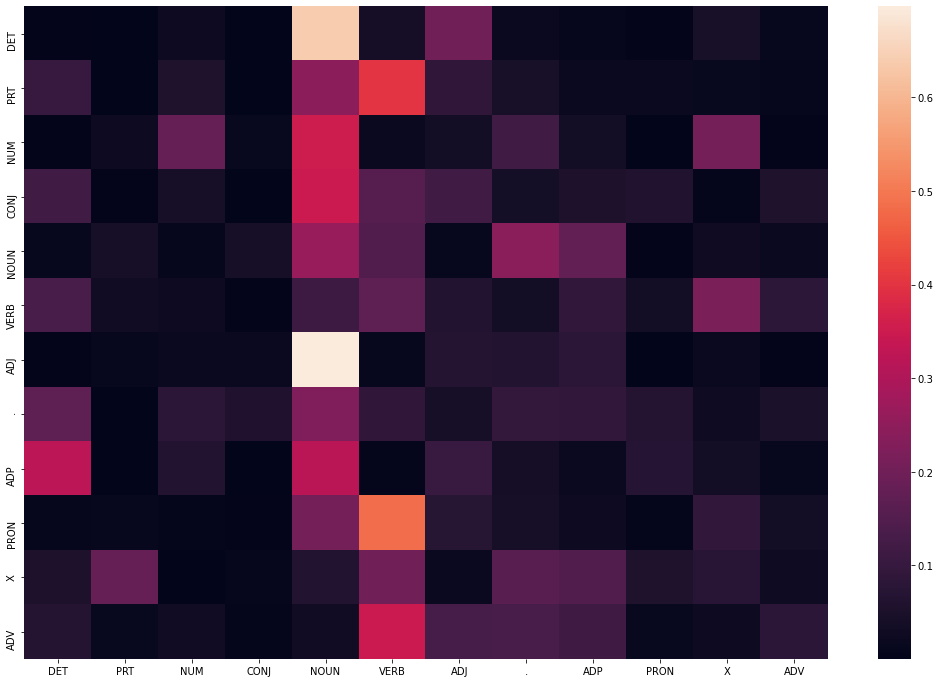

In [76]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


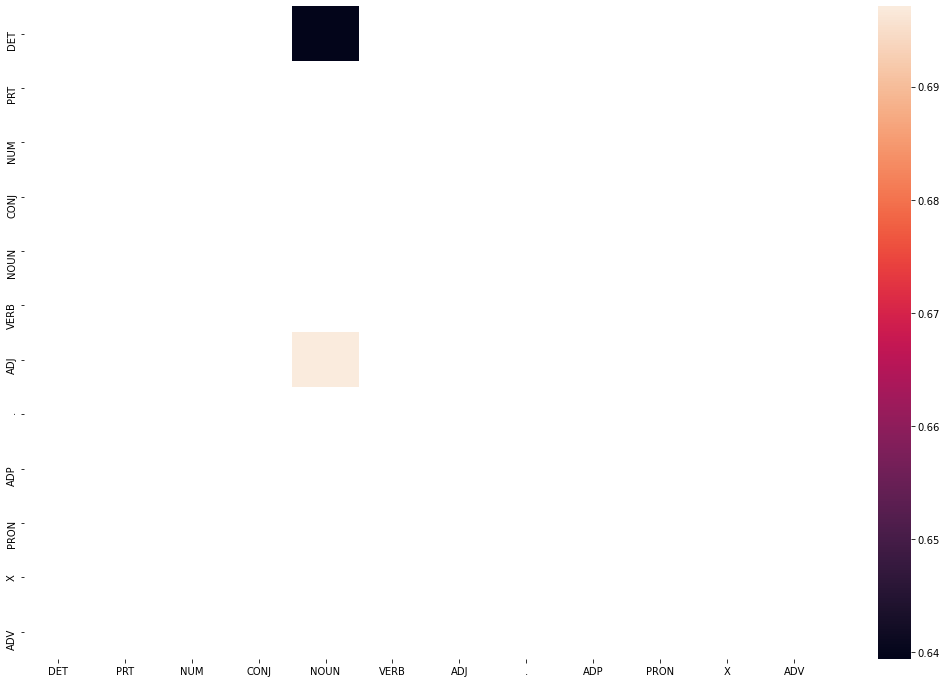

In [77]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Build the Vanilla Viterbi based POS tagger

In [78]:
len(train_tagged_words)

95367

In [79]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



## 4. Evaluating on Test Set

In [80]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(42)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('But', 'CONJ'),
  ('they', 'PRON'),
  ('have', 'VERB'),
  ('obtained', 'VERB'),
  ('8300', 'ADJ'),
  ('forms', 'NOUN'),
  ('without', 'ADP'),
  ('court', 'NOUN'),
  ('permission', 'NOUN'),
  ('and', 'CONJ'),
  ('used', 'VERB'),
  ('the', 'DET'),
  ('information', 'NOUN'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('help', 'VERB'),
  ('develop', 'VERB'),
  ('criminal', 'ADJ'),
  ('cases', 'NOUN'),
  ('.', '.')],
 [('Timex', 'NOUN'),
  ('had', 'VERB'),
  ('requested', 'VERB'),
  ('duty-free', 'ADJ'),
  ('treatment', 'NOUN'),
  ('for', 'ADP'),
  ('many', 'ADJ'),
  ('types', 'NOUN'),
  ('of', 'ADP'),
  ('watches', 'NOUN'),
  (',', '.'),
  ('covered', 'VERB'),
  ('*', 'X'),
  ('by', 'ADP'),
  ('58', 'NUM'),
  ('different', 'ADJ'),
  ('U.S.', 'NOUN'),
  ('tariff', 'NOUN'),
  ('classifications', 'NOUN'),
  ('.', '.')],
 [('At', 'ADP'),
  ('Greenville', 'NOUN'),
  ('High', 'NOUN'),
  ('School', 'NOUN'),
  (',', '.'),
  ('meanwhile', 'ADV'),
  (',', '.'),
  ('some', 'DET'),
  ('students', 'NOUN'),


In [81]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [82]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  25.614551305770874
[('But', 'CONJ'), ('they', 'PRON'), ('have', 'VERB'), ('obtained', 'VERB'), ('8300', 'NUM'), ('forms', 'NOUN'), ('without', 'ADP'), ('court', 'NOUN'), ('permission', 'NOUN'), ('and', 'CONJ'), ('used', 'VERB'), ('the', 'DET'), ('information', 'NOUN'), ('*-1', 'X'), ('to', 'PRT'), ('help', 'VERB'), ('develop', 'VERB'), ('criminal', 'ADJ'), ('cases', 'NOUN'), ('.', '.'), ('Timex', 'NOUN'), ('had', 'VERB'), ('requested', 'VERB'), ('duty-free', 'ADJ'), ('treatment', 'NOUN'), ('for', 'ADP'), ('many', 'ADJ'), ('types', 'NOUN'), ('of', 'ADP'), ('watches', 'NOUN'), (',', '.'), ('covered', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('58', 'NUM'), ('different', 'ADJ'), ('U.S.', 'NOUN'), ('tariff', 'NOUN'), ('classifications', 'DET'), ('.', '.'), ('At', 'ADP'), ('Greenville', 'NOUN'), ('High', 'NOUN'), ('School', 'NOUN'), (',', '.'), ('meanwhile', 'ADV'), (',', '.'), ('some', 'DET'), ('students', 'NOUN'), ('--', '.'), ('especially', 'ADV'), ('on', 'ADP'), ('the'

In [83]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [84]:
accuracy = len(check)/len(tagged_seq)
vanilla_accuracy=accuracy

In [85]:
accuracy

0.900990099009901

In [86]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
vanilla_incorrect_tagged_cases = incorrect_tagged_cases

In [87]:
incorrect_tagged_cases

[[('obtained', 'VERB'), (('8300', 'NUM'), ('8300', 'ADJ'))],
 [('tariff', 'NOUN'),
  (('classifications', 'DET'), ('classifications', 'NOUN'))],
 [('the', 'DET'), (('cheerleading', 'DET'), ('cheerleading', 'NOUN'))],
 [('cheerleading', 'NOUN'), (('squad', 'DET'), ('squad', 'NOUN'))],
 [('were', 'VERB'), (('crushed', 'DET'), ('crushed', 'ADJ'))],
 [('the', 'DET'), (('third-largest', 'DET'), ('third-largest', 'ADJ'))],
 [('the', 'DET'), (('fifth-largest', 'DET'), ('fifth-largest', 'ADJ'))],
 [('The', 'DET'), (('parishioners', 'DET'), ('parishioners', 'NOUN'))],
 [('All', 'DET'), (('Angels', 'DET'), ('Angels', 'NOUN'))],
 [('to', 'PRT'), (('chat', 'DET'), ('chat', 'VERB'))]]

In [88]:
print(test_tagged_words[:5])

['But', 'they', 'have', 'obtained', '8300']


In [89]:
print(train_tagged_words[:5])

[('The', 'DET'), ('7', 'NUM'), ('3\\/8', 'NUM'), ('%', 'NOUN'), ('term', 'NOUN')]


In [90]:
not_present_words=[]
for test_word in test_tagged_words:
    match_flag=0
    for train_word in train_tagged_words:
        if test_word==train_word[0]:
            match_flag=1
            break
    if match_flag==0:
        not_present_words.append(test_word)

In [91]:
not_present_words

['classifications',
 'cheerleading',
 'squad',
 'crushed',
 'third-largest',
 'fifth-largest',
 'parishioners',
 'Angels',
 'chat']

### Solve the problem of unknown words

### Technique 1 : To omit the emmission probability for the one's not present in training corpus

In [92]:
# Viterbi Heuristic
def Viterbi_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            # Checking for not present words
            if word not in not_present_words:
                state_probability = transition_p * emission_p
            else:
                state_probability = transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



In [93]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(42)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('But', 'CONJ'),
  ('they', 'PRON'),
  ('have', 'VERB'),
  ('obtained', 'VERB'),
  ('8300', 'ADJ'),
  ('forms', 'NOUN'),
  ('without', 'ADP'),
  ('court', 'NOUN'),
  ('permission', 'NOUN'),
  ('and', 'CONJ'),
  ('used', 'VERB'),
  ('the', 'DET'),
  ('information', 'NOUN'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('help', 'VERB'),
  ('develop', 'VERB'),
  ('criminal', 'ADJ'),
  ('cases', 'NOUN'),
  ('.', '.')],
 [('Timex', 'NOUN'),
  ('had', 'VERB'),
  ('requested', 'VERB'),
  ('duty-free', 'ADJ'),
  ('treatment', 'NOUN'),
  ('for', 'ADP'),
  ('many', 'ADJ'),
  ('types', 'NOUN'),
  ('of', 'ADP'),
  ('watches', 'NOUN'),
  (',', '.'),
  ('covered', 'VERB'),
  ('*', 'X'),
  ('by', 'ADP'),
  ('58', 'NUM'),
  ('different', 'ADJ'),
  ('U.S.', 'NOUN'),
  ('tariff', 'NOUN'),
  ('classifications', 'NOUN'),
  ('.', '.')],
 [('At', 'ADP'),
  ('Greenville', 'NOUN'),
  ('High', 'NOUN'),
  ('School', 'NOUN'),
  (',', '.'),
  ('meanwhile', 'ADV'),
  (',', '.'),
  ('some', 'DET'),
  ('students', 'NOUN'),


In [94]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_1(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  26.092119216918945
[('But', 'CONJ'), ('they', 'PRON'), ('have', 'VERB'), ('obtained', 'VERB'), ('8300', 'NUM'), ('forms', 'NOUN'), ('without', 'ADP'), ('court', 'NOUN'), ('permission', 'NOUN'), ('and', 'CONJ'), ('used', 'VERB'), ('the', 'DET'), ('information', 'NOUN'), ('*-1', 'X'), ('to', 'PRT'), ('help', 'VERB'), ('develop', 'VERB'), ('criminal', 'ADJ'), ('cases', 'NOUN'), ('.', '.'), ('Timex', 'NOUN'), ('had', 'VERB'), ('requested', 'VERB'), ('duty-free', 'ADJ'), ('treatment', 'NOUN'), ('for', 'ADP'), ('many', 'ADJ'), ('types', 'NOUN'), ('of', 'ADP'), ('watches', 'NOUN'), (',', '.'), ('covered', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('58', 'NUM'), ('different', 'ADJ'), ('U.S.', 'NOUN'), ('tariff', 'NOUN'), ('classifications', 'NOUN'), ('.', '.'), ('At', 'ADP'), ('Greenville', 'NOUN'), ('High', 'NOUN'), ('School', 'NOUN'), (',', '.'), ('meanwhile', 'ADV'), (',', '.'), ('some', 'DET'), ('students', 'NOUN'), ('--', '.'), ('especially', 'ADV'), ('on', 'ADP'), ('the

#### Evaluating tagging accuracy

In [95]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
tech1_accuracy = accuracy
print(accuracy)

0.9603960396039604


In [96]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
tech1_incorrect_tagged_cases = incorrect_tagged_cases
print(incorrect_tagged_cases)

[[('obtained', 'VERB'), (('8300', 'NUM'), ('8300', 'ADJ'))], [('were', 'VERB'), (('crushed', 'X'), ('crushed', 'ADJ'))], [('the', 'DET'), (('third-largest', 'NOUN'), ('third-largest', 'ADJ'))], [('the', 'DET'), (('fifth-largest', 'NOUN'), ('fifth-largest', 'ADJ'))]]


### Technique 2 : Applying Laplace Smoothing on the probabilities

In [97]:
# Viterbi Heuristic
#Applying laplace smoothing to emission and transition probabilities both
def Viterbi_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        flag=0
        #Checking if the word is present or not
        if word in not_present_words:
            flag=1
        
        p = [] 
        for tag in T:
            if flag==0:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
            else:
                if key == 0:
                    transition_p = (tags_df.loc['.', tag]+1)/len(words)
                else:
                    transition_p = (tags_df.loc[state[-1], tag]+1)/len(words)
                
            # compute emission and state probabilities based on flag values
            if flag==0:
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            else:
                emission_p = ((word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1])+1)/len(words)
            
            state_probability = transition_p * emission_p
              
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



In [98]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(42)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('But', 'CONJ'),
  ('they', 'PRON'),
  ('have', 'VERB'),
  ('obtained', 'VERB'),
  ('8300', 'ADJ'),
  ('forms', 'NOUN'),
  ('without', 'ADP'),
  ('court', 'NOUN'),
  ('permission', 'NOUN'),
  ('and', 'CONJ'),
  ('used', 'VERB'),
  ('the', 'DET'),
  ('information', 'NOUN'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('help', 'VERB'),
  ('develop', 'VERB'),
  ('criminal', 'ADJ'),
  ('cases', 'NOUN'),
  ('.', '.')],
 [('Timex', 'NOUN'),
  ('had', 'VERB'),
  ('requested', 'VERB'),
  ('duty-free', 'ADJ'),
  ('treatment', 'NOUN'),
  ('for', 'ADP'),
  ('many', 'ADJ'),
  ('types', 'NOUN'),
  ('of', 'ADP'),
  ('watches', 'NOUN'),
  (',', '.'),
  ('covered', 'VERB'),
  ('*', 'X'),
  ('by', 'ADP'),
  ('58', 'NUM'),
  ('different', 'ADJ'),
  ('U.S.', 'NOUN'),
  ('tariff', 'NOUN'),
  ('classifications', 'NOUN'),
  ('.', '.')],
 [('At', 'ADP'),
  ('Greenville', 'NOUN'),
  ('High', 'NOUN'),
  ('School', 'NOUN'),
  (',', '.'),
  ('meanwhile', 'ADV'),
  (',', '.'),
  ('some', 'DET'),
  ('students', 'NOUN'),


In [99]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_2(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  26.088366985321045
[('But', 'CONJ'), ('they', 'PRON'), ('have', 'VERB'), ('obtained', 'VERB'), ('8300', 'NUM'), ('forms', 'NOUN'), ('without', 'ADP'), ('court', 'NOUN'), ('permission', 'NOUN'), ('and', 'CONJ'), ('used', 'VERB'), ('the', 'DET'), ('information', 'NOUN'), ('*-1', 'X'), ('to', 'PRT'), ('help', 'VERB'), ('develop', 'VERB'), ('criminal', 'ADJ'), ('cases', 'NOUN'), ('.', '.'), ('Timex', 'NOUN'), ('had', 'VERB'), ('requested', 'VERB'), ('duty-free', 'ADJ'), ('treatment', 'NOUN'), ('for', 'ADP'), ('many', 'ADJ'), ('types', 'NOUN'), ('of', 'ADP'), ('watches', 'NOUN'), (',', '.'), ('covered', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('58', 'NUM'), ('different', 'ADJ'), ('U.S.', 'NOUN'), ('tariff', 'NOUN'), ('classifications', 'NOUN'), ('.', '.'), ('At', 'ADP'), ('Greenville', 'NOUN'), ('High', 'NOUN'), ('School', 'NOUN'), (',', '.'), ('meanwhile', 'ADV'), (',', '.'), ('some', 'DET'), ('students', 'NOUN'), ('--', '.'), ('especially', 'ADV'), ('on', 'ADP'), ('the

#### Evaluating tagging accuracy

In [100]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
tech2_accuracy = accuracy
print(accuracy)

0.9603960396039604


In [101]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
tech2_incorrect_tagged_cases = incorrect_tagged_cases
print(incorrect_tagged_cases)

[[('obtained', 'VERB'), (('8300', 'NUM'), ('8300', 'ADJ'))], [('were', 'VERB'), (('crushed', 'X'), ('crushed', 'ADJ'))], [('the', 'DET'), (('third-largest', 'NOUN'), ('third-largest', 'ADJ'))], [('the', 'DET'), (('fifth-largest', 'NOUN'), ('fifth-largest', 'ADJ'))]]


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [102]:
print("Vanilla Viterbi Accuracy: " +str(vanilla_accuracy))

Vanilla Viterbi Accuracy: 0.900990099009901


In [103]:
print("Technique 1's accuracy: "+str(tech1_accuracy))

Technique 1's accuracy: 0.9603960396039604


In [104]:
print("Technique 2's accuracy: "+str(tech2_accuracy))

Technique 2's accuracy: 0.9603960396039604


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

#### Cases are:-
1. [('tariff', 'NOUN'), (('classifications', 'DET'), ('classifications', 'NOUN'))]
2. [('the', 'DET'), (('cheerleading', 'DET'), ('cheerleading', 'NOUN'))]
3. [('cheerleading', 'NOUN'), (('squad', 'DET'), ('squad', 'NOUN'))]
4. [('The', 'DET'), (('parishioners', 'DET'), ('parishioners', 'NOUN'))]
5. [('All', 'DET'), (('Angels', 'DET'), ('Angels', 'NOUN'))]
6. [('to', 'PRT'), (('chat', 'DET'), ('chat', 'VERB'))]

In [105]:
for tag in vanilla_incorrect_tagged_cases:
    print(tag)

[('obtained', 'VERB'), (('8300', 'NUM'), ('8300', 'ADJ'))]
[('tariff', 'NOUN'), (('classifications', 'DET'), ('classifications', 'NOUN'))]
[('the', 'DET'), (('cheerleading', 'DET'), ('cheerleading', 'NOUN'))]
[('cheerleading', 'NOUN'), (('squad', 'DET'), ('squad', 'NOUN'))]
[('were', 'VERB'), (('crushed', 'DET'), ('crushed', 'ADJ'))]
[('the', 'DET'), (('third-largest', 'DET'), ('third-largest', 'ADJ'))]
[('the', 'DET'), (('fifth-largest', 'DET'), ('fifth-largest', 'ADJ'))]
[('The', 'DET'), (('parishioners', 'DET'), ('parishioners', 'NOUN'))]
[('All', 'DET'), (('Angels', 'DET'), ('Angels', 'NOUN'))]
[('to', 'PRT'), (('chat', 'DET'), ('chat', 'VERB'))]


In [106]:
for tag in tech1_incorrect_tagged_cases:
    print(tag)

[('obtained', 'VERB'), (('8300', 'NUM'), ('8300', 'ADJ'))]
[('were', 'VERB'), (('crushed', 'X'), ('crushed', 'ADJ'))]
[('the', 'DET'), (('third-largest', 'NOUN'), ('third-largest', 'ADJ'))]
[('the', 'DET'), (('fifth-largest', 'NOUN'), ('fifth-largest', 'ADJ'))]


In [107]:
for tag in tech2_incorrect_tagged_cases:
    print(tag)

[('obtained', 'VERB'), (('8300', 'NUM'), ('8300', 'ADJ'))]
[('were', 'VERB'), (('crushed', 'X'), ('crushed', 'ADJ'))]
[('the', 'DET'), (('third-largest', 'NOUN'), ('third-largest', 'ADJ'))]
[('the', 'DET'), (('fifth-largest', 'NOUN'), ('fifth-largest', 'ADJ'))]
